In [1]:
import urllib

english = "https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt"
polish = "https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/pl/pl_50k.txt"
swedish = "https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/sv/sv_50k.txt"
catalan = "https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/ca/ca_50k.txt"
italian = "https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/it/it_full.txt"
languages = {}
for name, url in {"english":english, "polish":polish, "swedish":swedish, "catalan":catalan, "italian":italian}.items():
    
    txt = urllib.request.urlopen(url).read().decode("UTF-8").split("\n")
    words = [word.split(" ")[0] for word in txt if len(word.split(" ")[0])>3]
    languages[name] = words[:5000]

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
list(map(len, languages.values()))

[5000, 5000, 5000, 5000, 5000]

In [81]:
# build the alphabet 
alphabet = set()
for words in languages.values():
    alphabet.update(set("".join(words)))
alphabet = ["$"]+ list(alphabet) + [" "]
print(len(alphabet))

# create a list of classes
target_labels = list(languages.keys())
target_labels

55


['english', 'polish', 'swedish', 'catalan', 'italian']

In [6]:
def char2index(char):
    return alphabet.index(char)

def char2tensor(char):
    tensor = torch.zeros(1, len(alphabet))
    tensor[0][char2index(char)] = 1
    return tensor

def word2tensor(word):
    word_tensor = torch.zeros(len(word), 1, len(alphabet))
    for i, char in enumerate(word):
        char_tensor = torch.zeros(1, len(alphabet))
        char_tensor[0][alphabet.index(char)] = 1
        word_tensor[i] = char_tensor
    return torch.permute(word_tensor, (1,0,2))

t = word2tensor("an")
t.shape

In [63]:
import random

def choice(obj):
    return obj[random.randint(0, len(obj)-1)]

def random_sample():
    category = choice(target_labels)
    category_tensor = torch.tensor(target_labels.index(category)).view(1) #from scalar to tensor
    word = choice(languages[category])
    word_tensor = word2tensor(word)
    return word, category, word_tensor, category_tensor

Define a custom Dataset of words and DataLoader for batch implementation.

In [15]:
import itertools
from torch.utils.data import Dataset, DataLoader


class WordDataset(Dataset):
    def __init__(self, data_dict):
        self.data = data_dict
        self.classes = list(data_dict.keys())
        
    def __getitem__(self, idx):
        category = choice(self.classes)
        word = choice(self.data[category])
        #word_tensor = torch.tensor([alphabet.index(c) for c in word])
        #category_tensor =  torch.tensor(target_labels.index(category)).view(1)
        return word, category #, word_tensor, category_tensor
        
    def __len__(self):
        return len(list(itertools.chain(*self.data.values())))
    
data = WordDataset(languages)

In [27]:
def collate_batch(batch):
    words, categories, padded_tensors , category_tensors, lengths = [], [], [], [], []
    for word, category in batch:
        words.append(word)
        categories.append(category)
        word_tensor = torch.tensor([alphabet.index(c) for c in word])
        lengths.append(len(word_tensor))
        padded_tensors.append(word_tensor)
        category_tensors.append(target_labels.index(category))
               
    padded_tensors = nn.utils.rnn.pad_sequence(padded_tensors, batch_first=True, padding_value=0)
    category_tensors = torch.tensor(category_tensors)
    lengths = torch.tensor(lengths)
    
    return words, categories, padded_tensors, lengths, category_tensors 

dataloader = DataLoader(data, batch_size = 12, shuffle = True, collate_fn = collate_batch)

In [65]:
for w, c, wt, le, ct in dataloader:
    print(w, c, wt.shape, le, ct )
    break

['maglietta', 'sole', 'going', 'writer', 'date', 'licenziata', 'fransk', 'pelle', 'torniamo', 'preoccupi', 'attityd', 'deposito'] ['italian', 'italian', 'english', 'english', 'english', 'italian', 'swedish', 'italian', 'italian', 'italian', 'swedish', 'italian'] torch.Size([12, 10]) tensor([ 9,  4,  5,  6,  4, 10,  6,  5,  8,  9,  7,  8]) tensor([4, 4, 0, 0, 0, 4, 2, 4, 4, 4, 2, 4])


In [180]:
class ProfRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(hidden_size + input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size + input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        combined = torch.cat((x,hidden), dim=1)
        ht = self.i2h(combined)
        ot = self.softmax(self.h2o(combined))
        return ot, ht
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [255]:
class ClassicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size) # [54, 64]
        self.fc = nn.Linear(hidden_size, len(target_labels)) 
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, batch):
        _, (hidden , cell)= self.rnn(batch) # (num_letters, 1word, hidden_size) , (1, 1word, hidden_size)
        probs = self.softmax(self.fc(hidden.squeeze(0))) #(1word, hidden_size)
        return probs

In [55]:
class ClassicRNNBatch(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first = True) # [54, 64]
        self.fc = nn.Linear(hidden_size, len(target_labels)) #
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, batch, lengths):
        embed = self.embedding(batch)
        riduced_embed = nn.utils.rnn.pack_padded_sequence(embed, lengths, enforce_sorted = False, batch_first = True)
        _, (hidden , cell)= self.rnn(riduced_embed) # (12_word, num_letters, hidden_size), (1, 12_words, hidden_size)
        probs = self.softmax(self.fc(hidden.squeeze(0))) #(12_words, hidden_size)
        return probs

In [351]:
n_hidden = 64
rnn1 = ClassicRNN(len(alphabet), n_hidden)
rnn2 = ProfRNN(len(alphabet), n_hidden, len(target_labels))
rnn3 = ClassicRNNBatch(len(alphabet), 42, n_hidden)
print(rnn3)

ClassicRNNBatch(
  (embedding): Embedding(55, 42, padding_idx=0)
  (rnn): LSTM(42, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


ClassicRNN and ProfRNN basically implement the same NN architecture:
* take as input a sequence of one-hot encoded vectors(letters)
* start with rnn/lstm layer followed by linear fc layer and logsoftmax activation

The only difference is that prof processes manually the sequence in a for loop one letter at a time. While in my implementation I use the the RNN layer which automatically processes the whole sequence and outputs the final hidden state. A more optimized implementation occures with batch processing. 
* The ClassicRNNBatch does not deal with one-hot encoding.
* It takes a batch of padded indexed words as input (tensors) and embedds the batch internally.
* Thus, the NN architecture starts with an Embedding layer 
* Before feeding teh embedded batch to rnn layer, we pack the padded embeddings into a compact structure
* After rnn layer there is a linear layer followed by log softmax activation

### Model training

In [194]:
### Prof model training
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn2.parameters(), lr = 0.0005)

def train2(word_tensor, category_tensor):
    hidden = rnn2.initHidden()
    optimizer.zero_grad()
    
    for char in range(word_tensor.size(0)):
        out, hidden = rnn2(word_tensor[char], hidden)
        
    loss = criterion(out, category_tensor)
    loss.backward()
    optimizer.step()
        
    return out, loss.item()
# _________________________________________________________________________________

def train1(word_tensor, category_tensor):
    optimizer.zero_grad()
    
    out = rnn1(word_tensor)
        
    loss = criterion(out, category_tensor)
    loss.backward()
    optimizer.step()
        
    return out, loss.item()

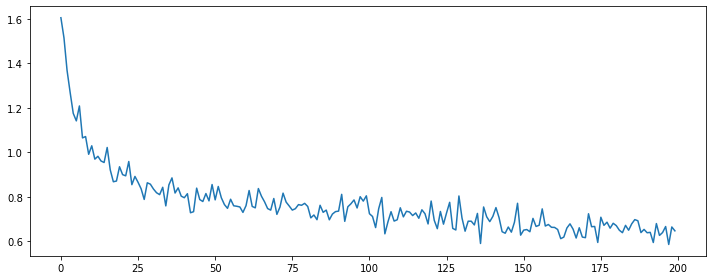

In [266]:
# lstm with Adam optimizer and lr = 0.0005 yields more stable learcning and allows to achieve lower loss

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(all_losses)
plt.tight_layout()
plt.show()

### Model Evaluation on a sample of 1000 words

In [223]:
topv, topk = torch.topk(rnn1(word_tensor), 3)
print(topv, topk) 

tensor([[-0.0313, -4.5725, -4.6144]], grad_fn=<TopkBackward0>) tensor([[2, 4, 1]])


In [218]:
target_labels[topk]

'swedish'

In [267]:
rnn1.eval()
y_true, y_pred = [],[]
for i in range(1000):
    word, category, word_tensor, cat_tensor = random_sample()
    probs = rnn1(word_tensor)
    topv, topk = torch.topk(probs, 1)
    y_true.append(category)
    y_pred.append(target_labels[topk])

              precision    recall  f1-score   support

     catalan       0.63      0.77      0.69       201
     english       0.69      0.76      0.72       201
     italian       0.80      0.71      0.75       192
      polish       0.91      0.84      0.87       202
     swedish       0.79      0.68      0.73       204

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



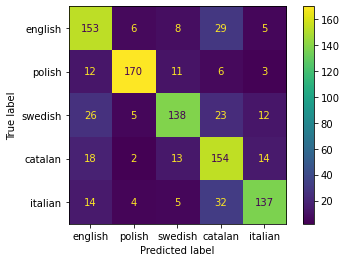

In [268]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels = target_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_labels)
disp.plot()
plt.show()

### Optimized training

In [58]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn3.parameters(), lr = 0.0005)

def train3(word_tensor, category_tensor, le):
    rnn3.train()
    optimizer.zero_grad()
    
    out = rnn3(word_tensor, le)
        
    # average loss per batch of 12 words
    loss = criterion(out, category_tensor)
    loss.backward()
    optimizer.step()
        
    return out, loss.item()

In [61]:
from tqdm.notebook import tqdm
rnn3.train()
all_losses = []
current_loss = 0

# range(1, 100000+1) in order to prevent loss starting from zero 
for iteration in tqdm(range(1, 100000+1)):
    word_b, category_b, word_tensor_b, le_b, category_tensor_b = next(iter(dataloader))
    out, loss = train3(word_tensor_b, category_tensor_b, le_b)
    current_loss += loss
    
    if iteration % 500 == 0:
        all_losses.append(current_loss/500)
        current_loss = 0    

  0%|          | 0/100000 [00:00<?, ?it/s]

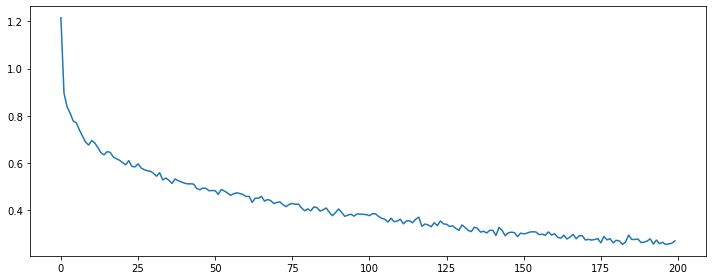

In [62]:
# training with batches of 12 words, lstm with Adam optimizer and learning rate 0.0005

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(all_losses)
plt.tight_layout()
plt.show()

In [77]:
rnn3.eval()
y_true, y_pred = [],[]
for i in range(1000):
    word, category, word_tensor, cat_tensor = random_sample()
    word_tensor = torch.tensor([alphabet.index(c) for c in word]).reshape(1, -1)
    lenght = torch.tensor(len(word)).view(1)
    probs = rnn3(word_tensor, lenght)
    topv, topk = torch.topk(probs, 1)
    y_true.append(category)
    y_pred.append(target_labels[topk])

              precision    recall  f1-score   support

     catalan       0.84      0.89      0.86       212
     english       0.84      0.91      0.88       190
     italian       0.89      0.82      0.85       198
      polish       0.97      0.93      0.95       185
     swedish       0.88      0.86      0.87       215

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



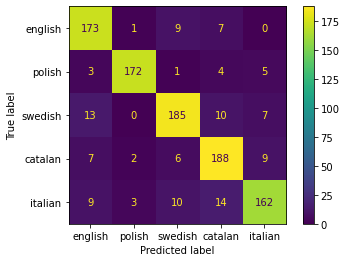

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels = target_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_labels)
disp.plot()
plt.show()

In [249]:
def predict(input_string, num_predictions=3):
    word_tensor = word2tensor(input_string)
    with torch.no_grad():
        topv, topk = rnn1(word_tensor).topk(num_predictions)
        predictions = [target_labels[i] for i in topk[0]]
        values = [round(i.item(), 2) for i in topv[0]]
        for value, prediction in zip(values, predictions):
            print("(%.2f) %s" % (value, prediction))

In [254]:
for sample in range(5):
    w,c, wt, ct = random_sample()
    print(c, w)
    predict(w)

italian aspettate
(-0.35) italian
(-1.40) english
(-3.62) polish
swedish lektion
(-0.60) swedish
(-1.60) english
(-1.71) catalan
polish więc
(-0.00) polish
(-7.55) catalan
(-8.44) english
swedish somnade
(-0.30) swedish
(-2.29) italian
(-2.39) catalan
catalan entrada
(-0.43) catalan
(-1.45) italian
(-2.45) swedish
